In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import joblib

# Налаштування
sns.set_style("whitegrid")

# Функція для розрахунку MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Завантажуємо денні дані для порівняння
df = pd.read_csv('../data/dataset_for_modeling.csv', index_col='DateTime', parse_dates=True)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()
y_test = df_daily.loc['2010-01-01':]['Global_active_power']

In [2]:
# Завантажуємо збережені моделі
sarima_model = joblib.load('../models/sarima_baseline_model.pkl')
xgb_tuned_model = joblib.load('../models/xgboost_tuned_model.pkl')
# (Аналогічно можна завантажити Prophet, RF, LSTM і т.д.)

# --- Прогноз SARIMA ---
preds_sarima = sarima_model.predict(n_periods=len(y_test))

# --- Прогноз XGBoost (наш найкращий ML) ---
# Готуємо ті ж ознаки, на яких він навчався
X_daily = df_daily.copy()
X_daily['day_of_week'] = X_daily.index.dayofweek
X_daily['month'] = X_daily.index.month
X_daily['day_of_year'] = X_daily.index.dayofyear
X_test_features = X_daily.loc['2010-01-01':].drop(columns=['Global_active_power'])
preds_xgb = xgb_tuned_model.predict(X_test_features)

# Зберігаємо прогнози в один DataFrame
predictions_df = pd.DataFrame({'Actual': y_test, 'SARIMA': preds_sarima, 'XGBoost_Tuned': preds_xgb})

# --- ДОДАЙТЕ ЦЕЙ РЯДОК ---
predictions_df.to_csv('../data/all_predictions.csv')
print("DataFrame з усіма прогнозами збережено у файл 'all_predictions.csv'")

DataFrame з усіма прогнозами збережено у файл 'all_predictions.csv'


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [3]:
# Словник для зберігання результатів
results = {}

# Розраховуємо метрики для кожної моделі
for model_name in predictions_df.columns:
    if model_name != 'Actual':
        preds = predictions_df[model_name]
        results[model_name] = {
            'MAE': mean_absolute_error(y_test, preds),
            'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
            'MAPE (%)': mean_absolute_percentage_error(y_test, preds),
            'R²': r2_score(y_test, preds),
            'Explained Variance': explained_variance_score(y_test, preds)
        }

# Створюємо фінальну таблицю
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='MAE') # Сортуємо за найкращим MAE

print("Порівняльна таблиця продуктивності моделей:")
display(results_df)

Порівняльна таблиця продуктивності моделей:


/var/folders/qx/qcg8gq_95sj0ckv67r12b2yw0000gn/T/ipykernel_33269/227526279.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/qx/qcg8gq_95sj0ckv67r12b2yw0000gn/T/ipykernel_33269/227526279.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


,MAE,RMSE,MAPE (%),R²,Explained Variance
XGBoost_Tuned,166.508149,212.489151,inf,0.280476,0.298388
SARIMA,275.601838,330.523405,inf,-0.740910,-0.255750


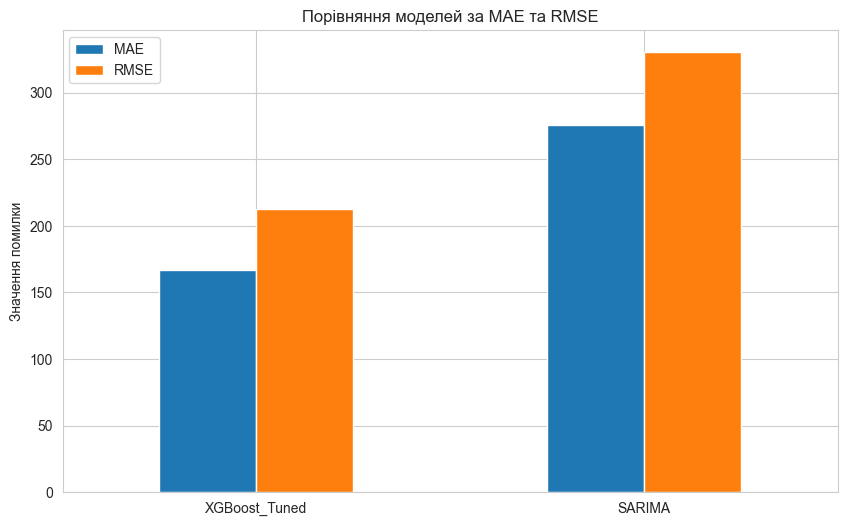

In [4]:
results_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title('Порівняння моделей за MAE та RMSE')
plt.ylabel('Значення помилки')
plt.xticks(rotation=0)
plt.show()